In [1]:
#pip3 install google.colab
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

###  Libraries

In [17]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

import torch

import os
import sys

from Autoencoder import Autoencoder, CD_Autoencoder
from Datasets_Functions import *
from Visualization import Visualization
from Evaluations.Evaluation import Evaluator

### Global Variables

In [2]:
path_to_module = './' # 'C:\\Users\\PAPASOFT INC\\Desktop\\SOFT_SIL'
sys.path.append(path_to_module)
os.environ['OMP_NUM_THREADS'] = '6'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

### Visualization

In [18]:
color_list = list(mcolors.CSS4_COLORS.keys()) + list(mcolors.XKCD_COLORS.keys())
np.random.shuffle(color_list)
color_list = ['deepskyblue', 'gold', 'hotpink', 'limegreen'] + color_list
visualization = Visualization(color_list,15,autoencoder)

### ***LOAD DATASET***

In [3]:
hashmap = get_hashmap(path_to_module)
print(hashmap.keys())
dataset_name = 'Pendigits'
dataset_properties = hashmap[dataset_name]
print(dataset_properties)
batch_size = dataset_properties['batch_size'] #= 30
n_clusters = dataset_properties['n_clusters'] #= 3
dataloader, input_dim, data_np, labels = function_get_dataset(dataset_properties)
print('Data_Shape is:', input_dim)
print('Batches Number is:', len(dataloader))

dict_keys(['10x73k', 'TCGA', 'coil20', 'eMNIST_balanced_letters', 'eMNIST_mnist', 'eMNIST_balanced_digits', 'Dermatology', 'Ecoil', 'Iris', 'Rings', 'Wine', 'Australian', 'Moons', 'Squeezed_Gauss', 'Gauss_Densities', 'Pendigits', 'fashionMNIST', '3DSpheres', '20_NewsGroups', 'COIL20', 'CIFAR10', 'STL10', 'R15', 'R3'])
{'batch_size': 256, 'n_clusters': 10, 'module_name': 'Datasets.Datasets', 'function_name': 'load_Pendigits', 'option_name': ''}
Data_Shape is: 16
Batches Number is: 43


### Parameters

In [11]:
# Latent Dimension, Number of Channels and Negative Slope
latent_dim = 5
n_channels = 1
n_clusters = dataset_properties['n_clusters']

# Batch Size and Number of Clusters
batch_size = dataset_properties['batch_size']
negative_slope = 0

# Pre-Training Epochs and Learning Rate
n_pret_epochs = 100
pret_lr = 1e-3

# Lamdas, Training Epochs and Learning Rate
n_epochs = 100
lr = 3e-4
sil_lambda = 0.01
entr_lambda = 0.01

kmeans_initialization = True
pretrain = True
isCD = True

### Create Autoencoder Model

### MLP Autoencoder

In [12]:
autoencoder = Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope)
autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
autoencoder.set_path()

autoencoder = autoencoder.to(device)

In [13]:
autoencoder

Autoencoder(
  (encoder_model): Sequential(
    (0): Linear(in_features=16, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0, inplace=True)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): LeakyReLU(negative_slope=0, inplace=True)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=500, out_features=2000, bias=True)
    (7): LeakyReLU(negative_slope=0, inplace=True)
    (8): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=2000, out_features=5, bias=True)
    (10): Tanh()
    (11): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cluster_model): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=False)
  )
  (decoder_model): Sequential(
    (0): Linear(in_features=5, out_features=2000,

### Convolutional-Deconvolution Autoencoder

In [8]:
autoencoder = CD_Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope, n_channels=n_channels)
autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
autoencoder.set_path()

autoencoder = autoencoder.to(device)

In [9]:
autoencoder

CD_Autoencoder(
  (encoder_model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0, inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0, inplace=True)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=5, bias=True)
    (11): Tanh()
    (12): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cluster_model): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=False)
  )
  (decoder_mod

### Pretrain Autoencoder Model

In [14]:
if(pretrain):
    autoencoder.pretrain_autoencoder()
    autoencoder.save_pretrained_weights()
else:
    model_save_path = autoencoder.dataDirPath + "\\Weigths\\autoencoder_weights.pth"
    autoencoder.load_state_dict(torch.load(model_save_path))
    normPreTrEpochs = autoencoder.preTrEpochs  
    autoencoder.preTrEpochs = 1
    autoencoder.pretrain_autoencoder()
    autoencoder.preTrRpochs = normPreTrEpochs

Epoch: 0, Loss: 5.013455
Epoch: 1, Loss: 2.721829
Epoch: 2, Loss: 2.258210
Epoch: 3, Loss: 2.069733
Epoch: 4, Loss: 1.874406
Epoch: 5, Loss: 1.631513
Epoch: 6, Loss: 1.456189
Epoch: 7, Loss: 1.347331
Epoch: 8, Loss: 1.232456
Epoch: 9, Loss: 1.103518
Epoch: 10, Loss: 0.976516
Epoch: 11, Loss: 0.894642
Epoch: 12, Loss: 0.812147
Epoch: 13, Loss: 0.768733
Epoch: 14, Loss: 0.709719
Epoch: 15, Loss: 0.625070
Epoch: 16, Loss: 0.774795
Epoch: 17, Loss: 0.610509
Epoch: 18, Loss: 0.529891
Epoch: 19, Loss: 0.480284
Epoch: 20, Loss: 0.469752
Epoch: 21, Loss: 0.425791
Epoch: 22, Loss: 0.417553
Epoch: 23, Loss: 0.419305
Epoch: 24, Loss: 0.376660
Epoch: 25, Loss: 0.415306
Epoch: 26, Loss: 0.359736
Epoch: 27, Loss: 0.316770
Epoch: 28, Loss: 0.325759
Epoch: 29, Loss: 0.299061
Epoch: 30, Loss: 0.293946
Epoch: 31, Loss: 0.296530
Epoch: 32, Loss: 0.280469
Epoch: 33, Loss: 0.284347
Epoch: 34, Loss: 0.274795
Epoch: 35, Loss: 0.266659
Epoch: 36, Loss: 0.252389
Epoch: 37, Loss: 0.244718
Epoch: 38, Loss: 0.232

In [15]:
# Initialize the clustering layer using k-means
if kmeans_initialization: autoencoder.kmeans_initialization(100)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0d1e60df30>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0d1e60df30>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0d1e60df30>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0d12f1f910>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0d12f1f910>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0d1e60df30>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0d12f1f910>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0d1e60df30>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0d1e60df30>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0d12f1f910>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0d1e60df30>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0d1e60df30>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [16]:
"""
while True:
    # Code block to execute repeatedly
    autoencoder.trEpochs = 10
    autoencoder.train_autoencoder(silhouette_method = "default")
    visualization.makeExcel()
    #visualization.makePlot(useTSNE=False)
    #visualization.makePlot(useTSNE=True)
    visualization.plot_3D()

    # Check the condition to exit the loop
    if autoencoder.experimentName == "Experiment_400":
        break
"""
autoencoder.train_autoencoder()

# visualization.makeExcel()
# visualization.makePlot(useTSNE=False)
visualization.plot_tsne()

Ep: 0 Rec L: 0.1473 Cl L: 0.4734 Entropy: 1.1784 SSil: -4.3374 SIL: 0.0000 ACC: 0.76 PUR: 0.76 NMI: 0.67 ARI: 0.58
Ep: 1 Rec L: 0.1212 Cl L: 0.4727 Entropy: 1.1510 SSil: -4.2732 SIL: 0.0000 ACC: 0.76 PUR: 0.76 NMI: 0.67 ARI: 0.58
Ep: 2 Rec L: 0.1272 Cl L: 0.4715 Entropy: 1.1261 SSil: -4.1468 SIL: 0.0000 ACC: 0.76 PUR: 0.76 NMI: 0.68 ARI: 0.58
Ep: 3 Rec L: 0.1355 Cl L: 0.4699 Entropy: 1.1019 SSil: -3.9938 SIL: 0.0000 ACC: 0.76 PUR: 0.76 NMI: 0.68 ARI: 0.58
Ep: 4 Rec L: 0.1318 Cl L: 0.4681 Entropy: 1.0782 SSil: -3.8114 SIL: 0.0000 ACC: 0.76 PUR: 0.76 NMI: 0.68 ARI: 0.58
Ep: 5 Rec L: 0.1342 Cl L: 0.4652 Entropy: 1.0485 SSil: -3.5226 SIL: 0.0000 ACC: 0.76 PUR: 0.76 NMI: 0.68 ARI: 0.57
Ep: 6 Rec L: 0.1294 Cl L: 0.4614 Entropy: 1.0205 SSil: -3.1410 SIL: 0.0000 ACC: 0.76 PUR: 0.76 NMI: 0.68 ARI: 0.58
Ep: 7 Rec L: 0.1275 Cl L: 0.4571 Entropy: 0.9899 SSil: -2.7068 SIL: 0.0000 ACC: 0.76 PUR: 0.76 NMI: 0.68 ARI: 0.58
Ep: 8 Rec L: 0.1290 Cl L: 0.4517 Entropy: 0.9570 SSil: -2.1712 SIL: 0.0000 ACC: 

Ep: 71 Rec L: 0.1451 Cl L: 0.0710 Entropy: 0.0377 SSil: 35.8973 SIL: 0.0000 ACC: 0.81 PUR: 0.81 NMI: 0.76 ARI: 0.66
Ep: 72 Rec L: 0.1457 Cl L: 0.0709 Entropy: 0.0372 SSil: 35.9148 SIL: 0.0000 ACC: 0.81 PUR: 0.81 NMI: 0.76 ARI: 0.66
Ep: 73 Rec L: 0.1486 Cl L: 0.0742 Entropy: 0.0361 SSil: 35.5779 SIL: 0.0000 ACC: 0.81 PUR: 0.81 NMI: 0.76 ARI: 0.67
Ep: 74 Rec L: 0.1426 Cl L: 0.0710 Entropy: 0.0347 SSil: 35.8969 SIL: 0.0000 ACC: 0.81 PUR: 0.81 NMI: 0.76 ARI: 0.66
Ep: 75 Rec L: 0.1522 Cl L: 0.0733 Entropy: 0.0345 SSil: 35.6677 SIL: 0.0000 ACC: 0.81 PUR: 0.81 NMI: 0.76 ARI: 0.66
Ep: 76 Rec L: 0.1442 Cl L: 0.0711 Entropy: 0.0327 SSil: 35.8930 SIL: 0.0000 ACC: 0.81 PUR: 0.81 NMI: 0.76 ARI: 0.66
Ep: 77 Rec L: 0.1397 Cl L: 0.0676 Entropy: 0.0320 SSil: 36.2367 SIL: 0.0000 ACC: 0.80 PUR: 0.80 NMI: 0.75 ARI: 0.65
Ep: 78 Rec L: 0.1582 Cl L: 0.0715 Entropy: 0.0318 SSil: 35.8547 SIL: 0.0000 ACC: 0.80 PUR: 0.80 NMI: 0.75 ARI: 0.65
Ep: 79 Rec L: 0.1535 Cl L: 0.0680 Entropy: 0.0293 SSil: 36.1985 SIL: 0.0

NameError: name 'visualization' is not defined

/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11002 samples in 0.016s...
[t-SNE] Computed neighbors for 11002 samples in 0.245s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11002
[t-SNE] Computed conditional probabilities for sample 2000 / 11002
[t-SNE] Computed conditional probabilities for sample 3000 / 11002
[t-SNE] Computed conditional probabilities for sample 4000 / 11002
[t-SNE] Computed conditional probabilities for sample 5000 / 11002
[t-SNE] Computed conditional probabilities for sample 6000 / 11002
[t-SNE] Computed conditional probabilities for sample 7000 / 11002
[t-SNE] Computed conditional probabilities for sample 8000 / 11002
[t-SNE] Computed conditional probabilities for sample 9000 / 11002
[t-SNE] Computed conditional probabilities for sample 10000 / 11002
[t-SNE] Computed conditional probabilities for sample 11000 / 11002
[t-SNE] Computed conditional probabilities for sample 11002 / 11002
[t-SNE] Mean sigma: 0.093093
[t-SNE] KL divergence

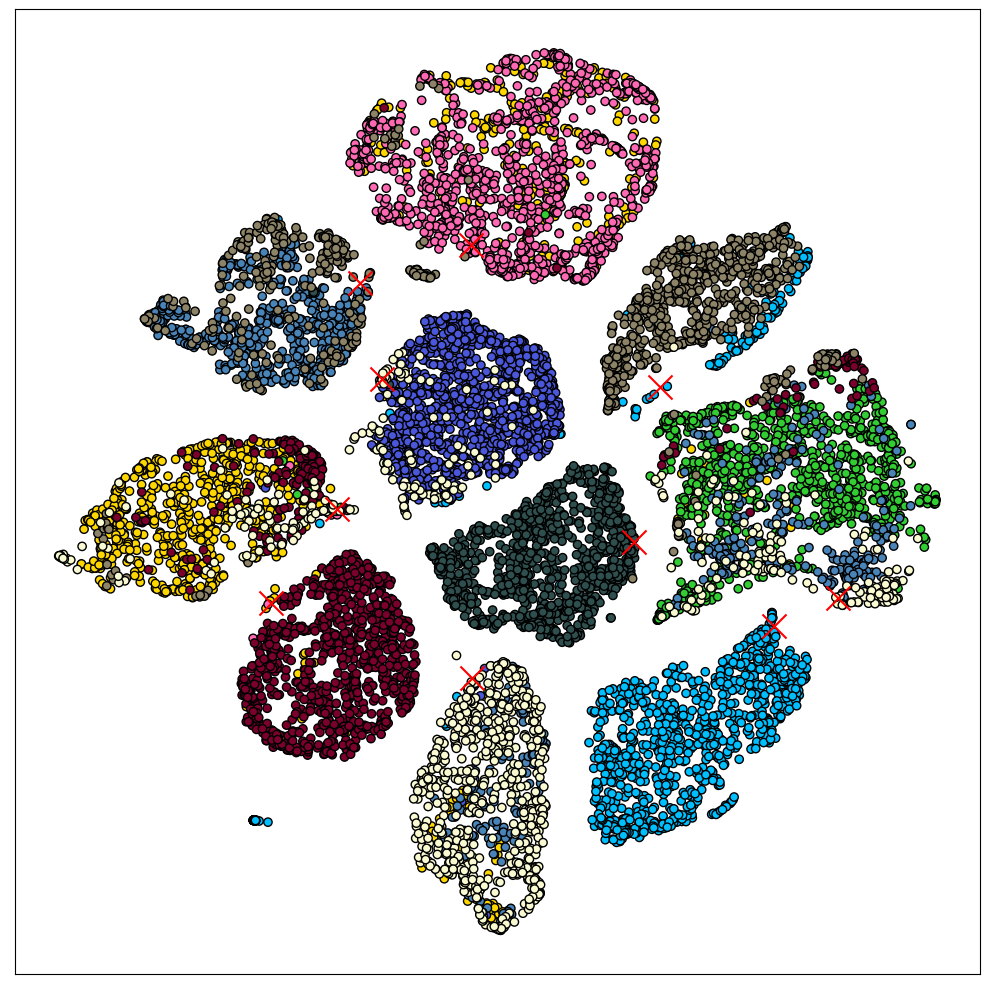

In [19]:
visualization.plot_tsne()